This demo shows how SentenceTransformers can be used to map texts and images to the same vector space.

The model, use the OpenAI CLIP Model, which has been trained on a large set of images and image alt texts.

The original CLIP Model only works for English, hence, we used Multilingual Knowlegde Distillation to make this model work with 50+ languages. I used the Unsplash Dataset Lite, which contains about 25k images. 

The 25k images is minimal but good for our demostration purposes. If you search for the specific terms, the chances are high that no such photo really exist in the collection but our model will still output an image.

In [2]:
%%capture
!pip install sentence-transformers


In [3]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

# Here we load the multilingual CLIP model. Note, this model can only encode text.
# If you need embeddings for images, you must load the 'clip-ViT-B-32' model
model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

In [4]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)

  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

In [5]:
# Let's get the and compute compute the embeddings
# Destribute pre-computed embeddings to scale up the performance
# Or we can encode an image, by using the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    #For embedding images, we need the non-multilingual CLIP model
    img_model = SentenceTransformer('clip-ViT-B-32')

    img_names = list(glob.glob('photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = img_model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

  0%|          | 0.00/51.8M [00:00<?, ?B/s]

Images: 24996


In [6]:
# Import pytorch and model images
import torch
filepath = 'photos/'+img_names[0]
one_emb = torch.tensor(img_emb[0])
img_model = SentenceTransformer('clip-ViT-B-32')
comb_emb = img_model.encode(Image.open(filepath), convert_to_tensor=True).cpu()
print(util.cos_sim(one_emb, comb_emb))

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


tensor([[1.0000]])


In [7]:
# Next, we define a search function.
def search(query, k=3):
    # First, we encode the query (which can either be an image or a text string)
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Let's use the util.semantic_search function, which computes the cosine-similarity between the query embedding and all image embeddings.
    # then returns the top_k highest ranked images, which we output
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=200))

Search interested Pictures

Query:


'gato en una silla'

I-YJ-gaJNaw.jpg


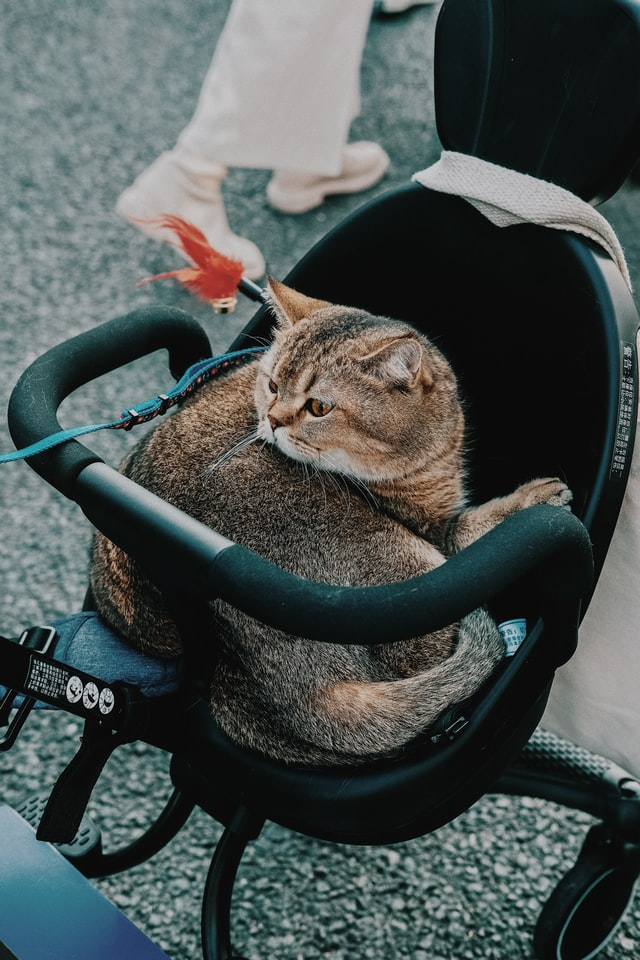

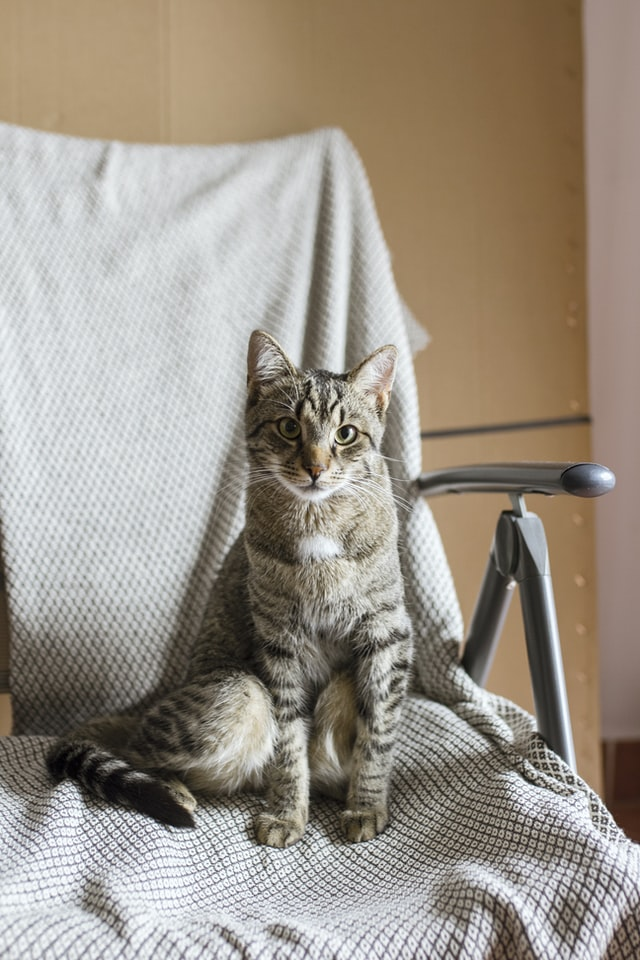

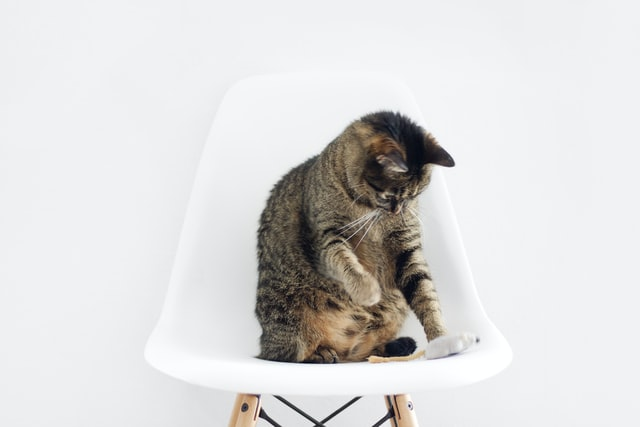

CgGDzMYdYw8.jpg
kjERLXaHjXc.jpg


In [8]:
#spanish: A cat on a chair
search("gato en una silla")

Query:


'Many fish'

_MJKaRig1Ic.jpg


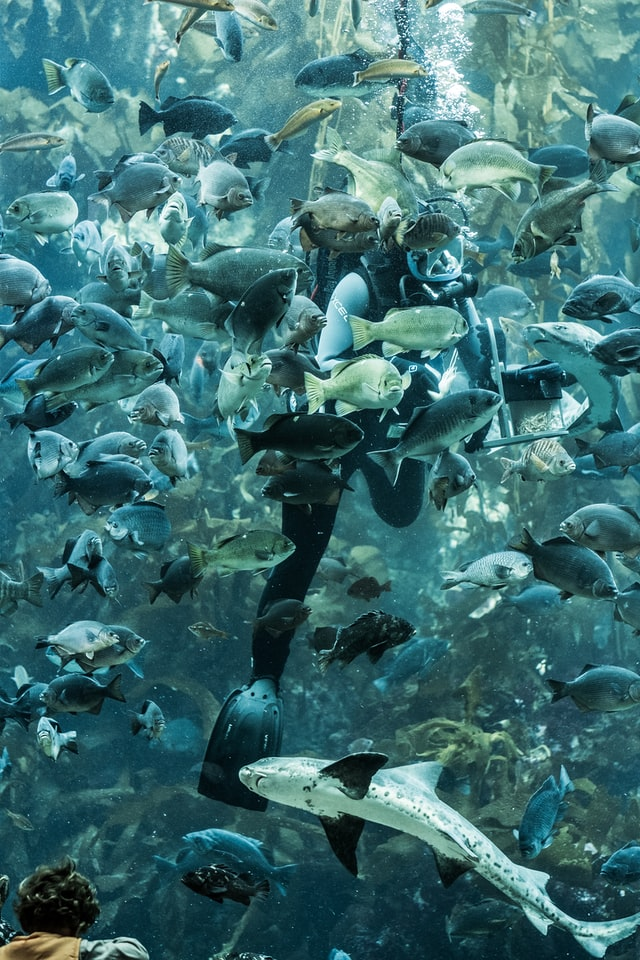

H22jcGTyrS4.jpg


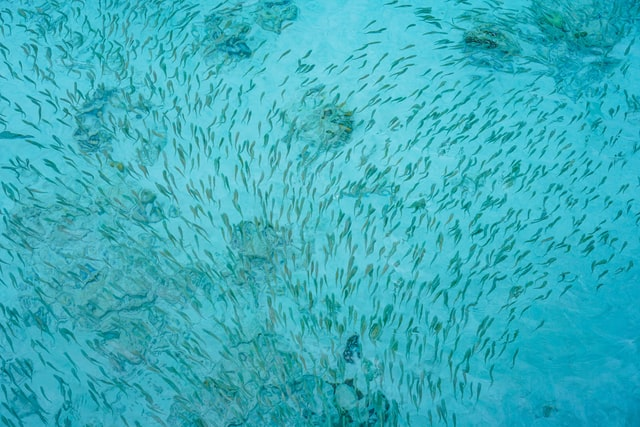

IXZru8ftAy0.jpg


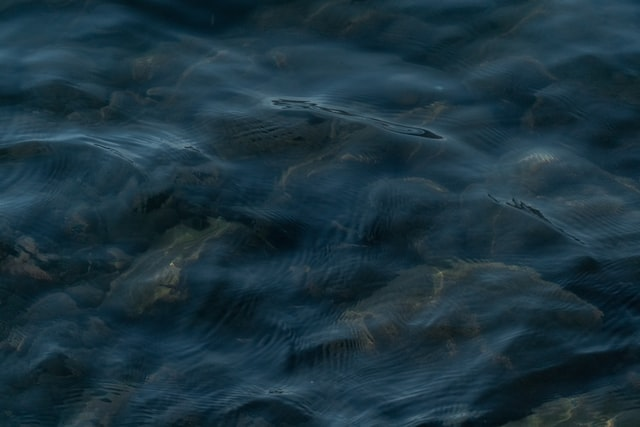

In [9]:
search("Many fish")

Query:


'dos perros jugando en la nieve'

lyStEjlKNSw.jpg


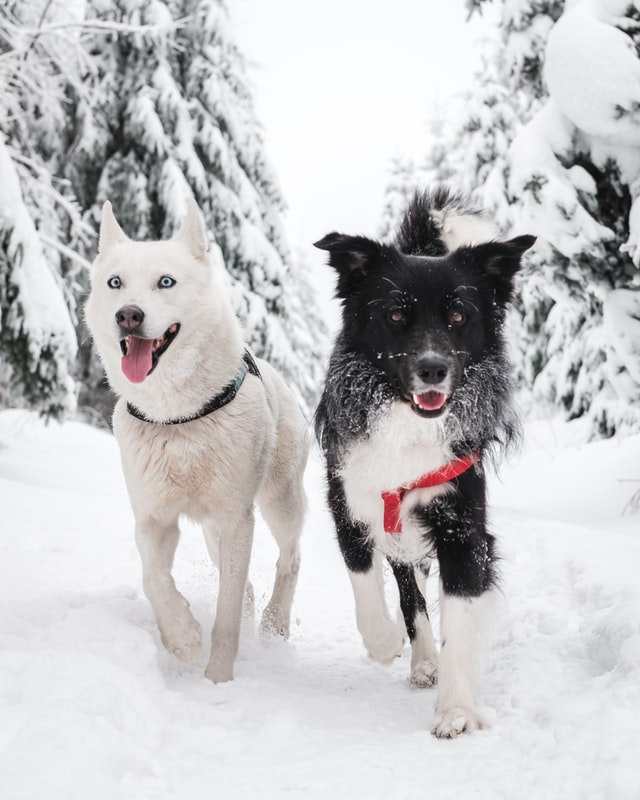

FAcSe7SjDUU.jpg


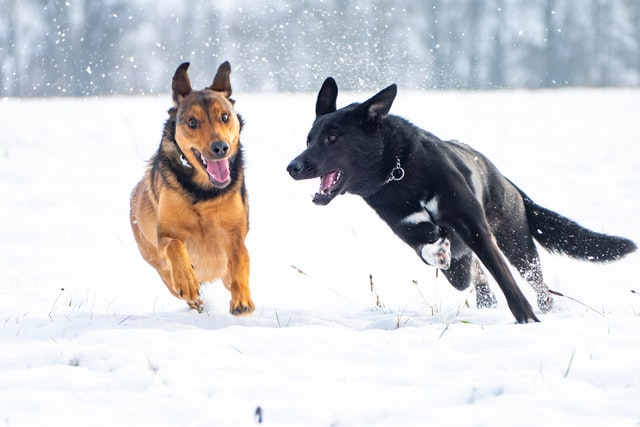

Hb6nGDgWztE.jpg


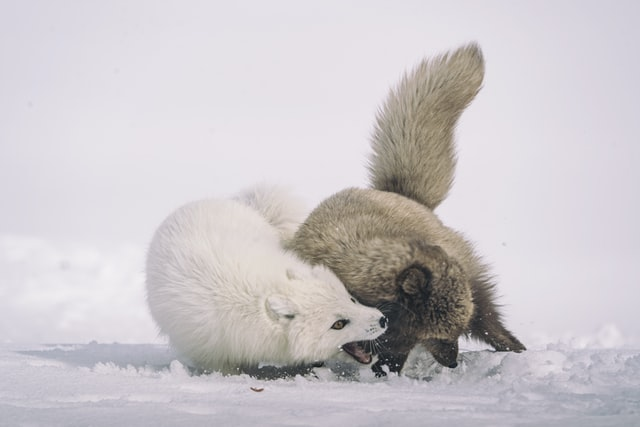

In [10]:
#Spanish: Two dogs playing in the snow
search("dos perros jugando en la nieve")

Query:


'Um pôr do sol na praia'

uAHyuK3X8GM.jpg


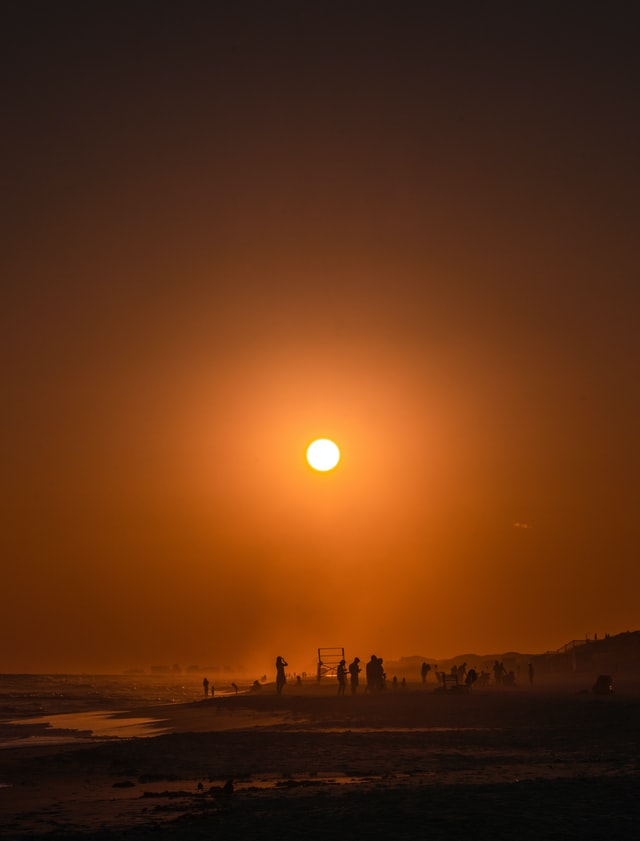

hxMAXDhpAPY.jpg


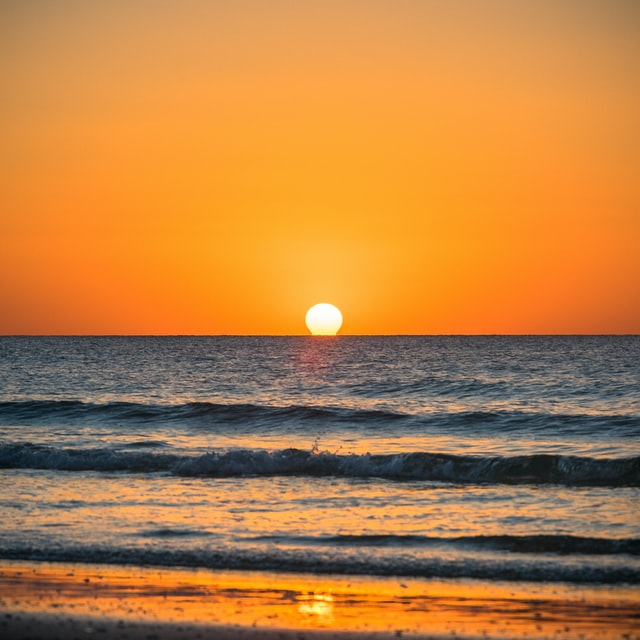

JC5U3Eyiyr4.jpg


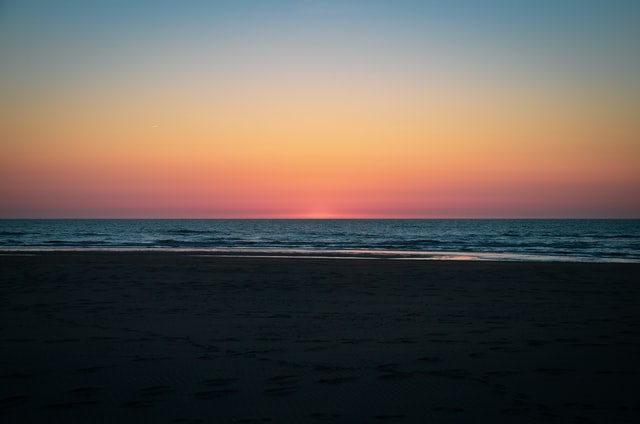

In [12]:
 #Portuguese:A sunset on the beach
search("Um pôr do sol na praia")

Query:


'watu wengi'

k1QqUSvRObc.jpg


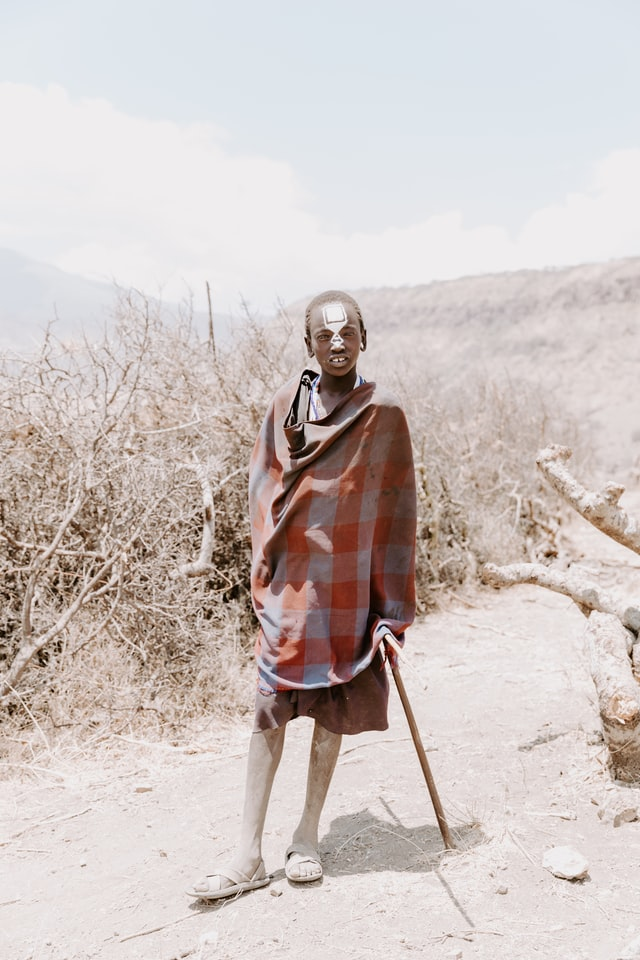

zeNeAUwoJvs.jpg


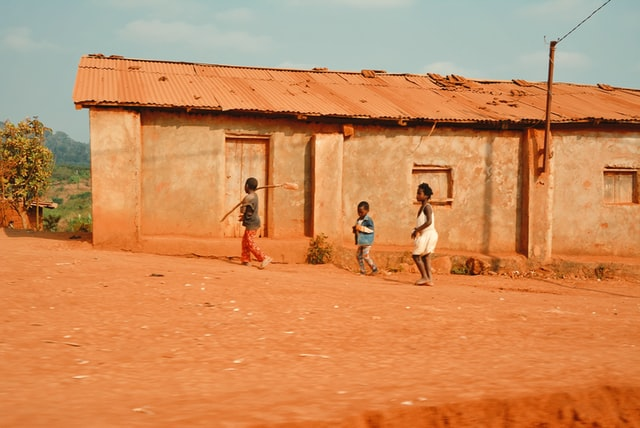

9yCLzkpYZwY.jpg


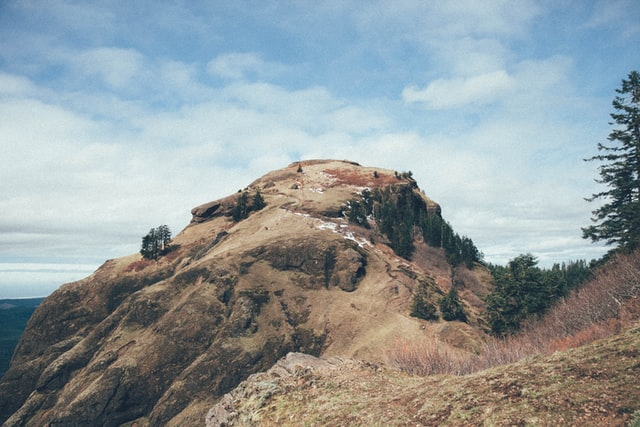

In [13]:
#Swahili: many people
search("watu wengi")

Query:


'пляж с пальмами'

_6iV1AJZ53s.jpg


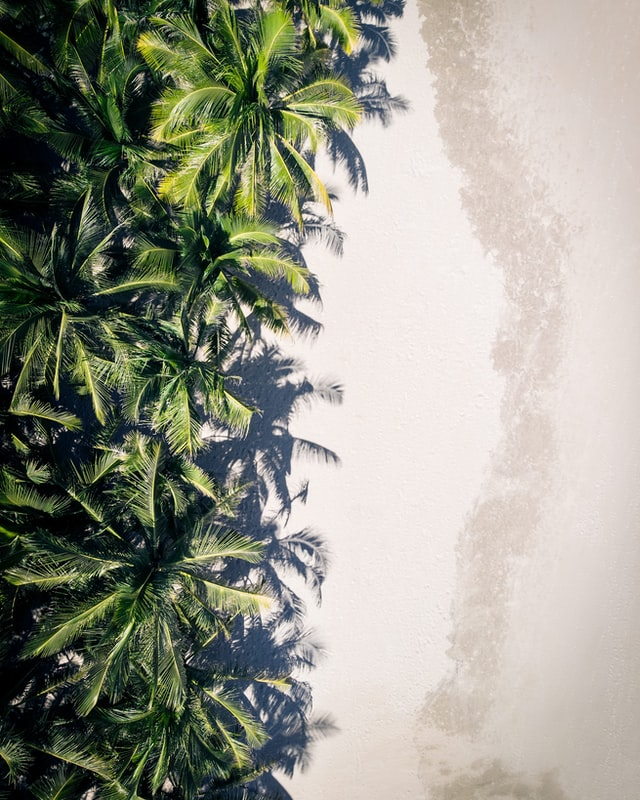

35onhFFHSWk.jpg


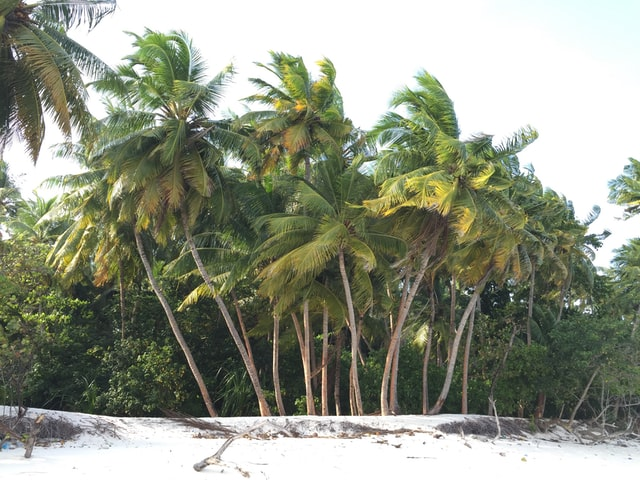

7rrgPPljqYU.jpg


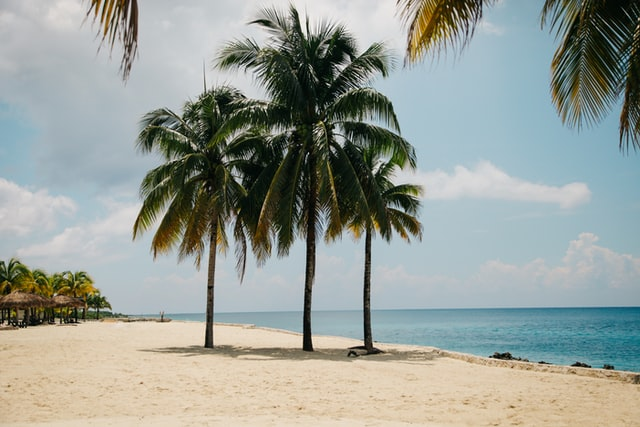

In [14]:

#Russian: A beach with palm trees
search("пляж с пальмами")

Query:


"New York'ta gece"

8nCMOFYyXF4.jpg


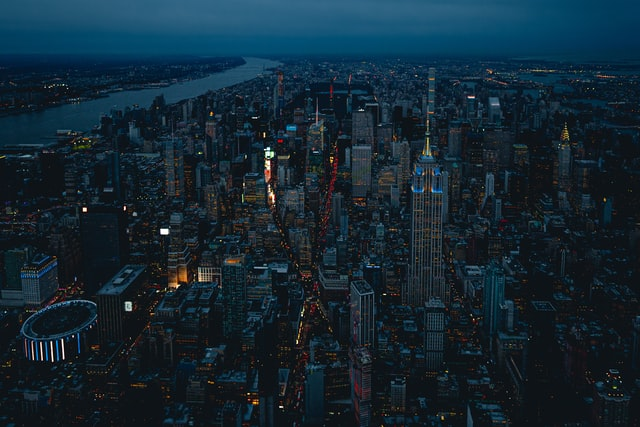

FGjR4IGwP7U.jpg


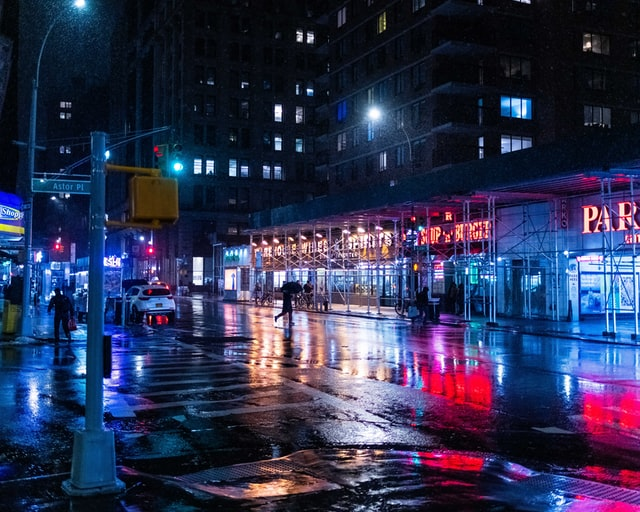

ZAOEjcpdMkc.jpg


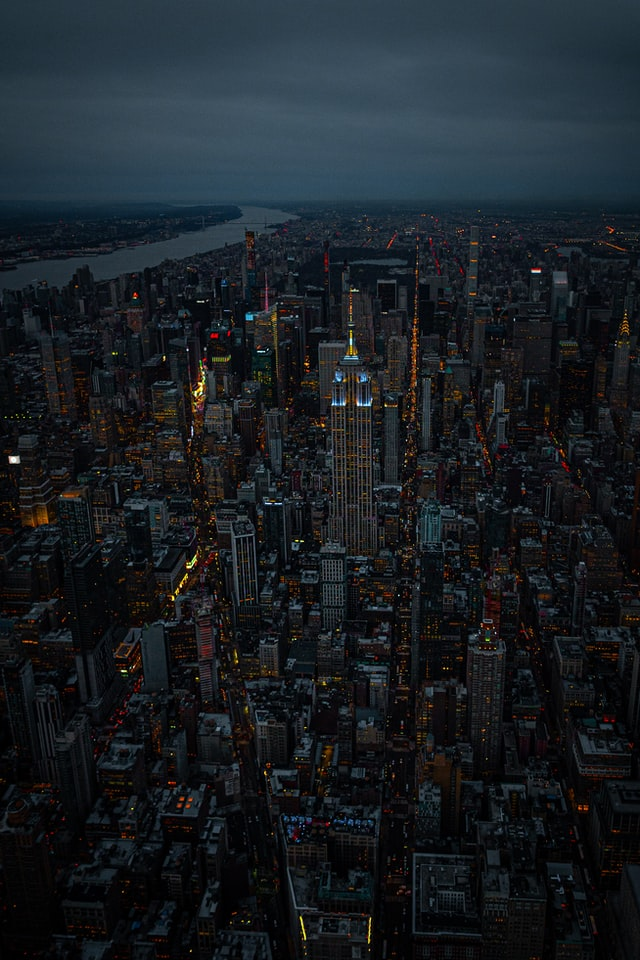

In [15]:
#Turkish: New York at night
search("New York'ta gece")

Query:


'公園の犬'

0O9A0F_d1qA.jpg


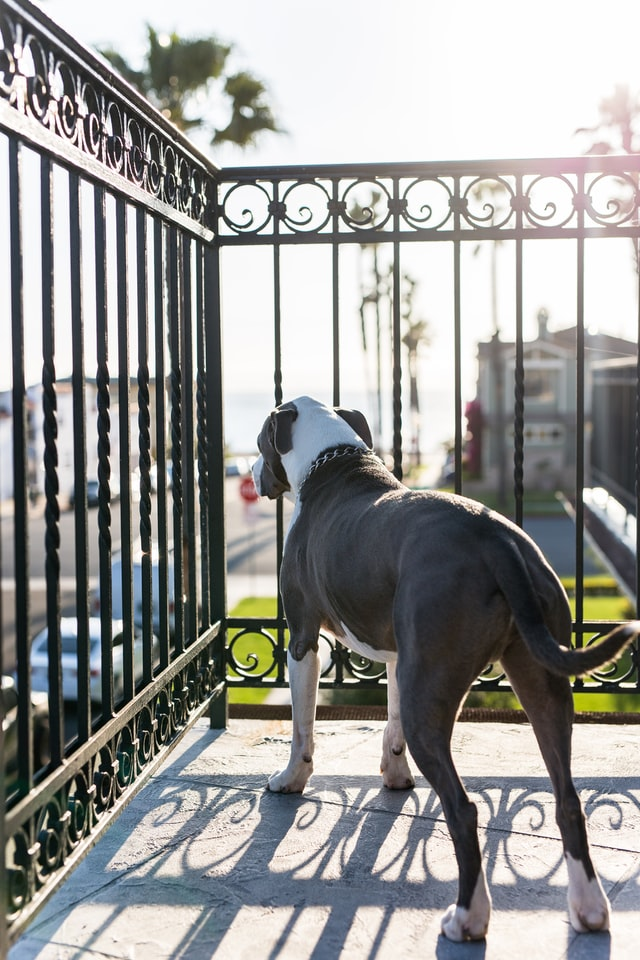

ROJLfAbL1Ig.jpg


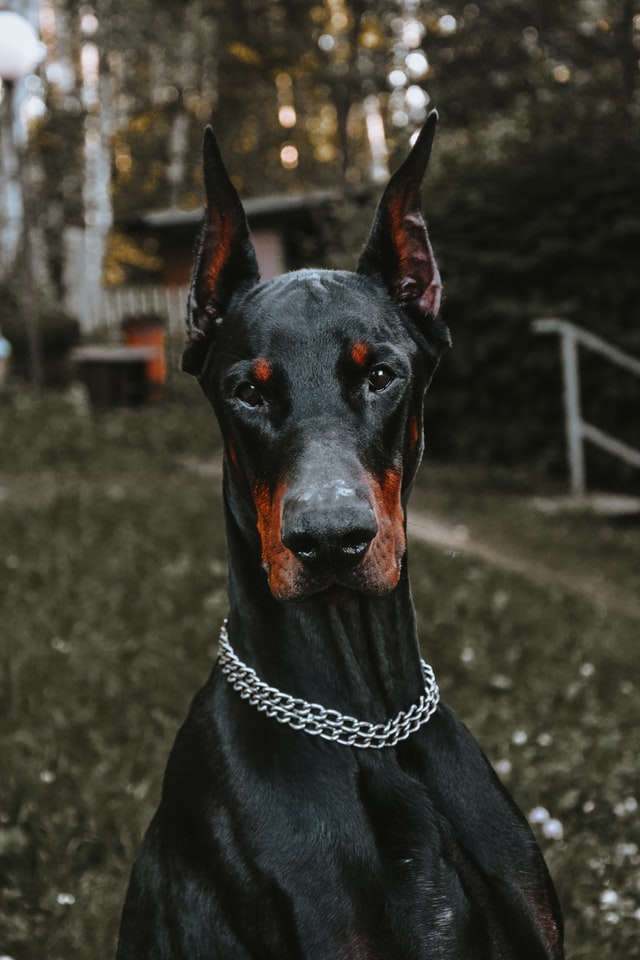

4mdsPUtN0P0.jpg


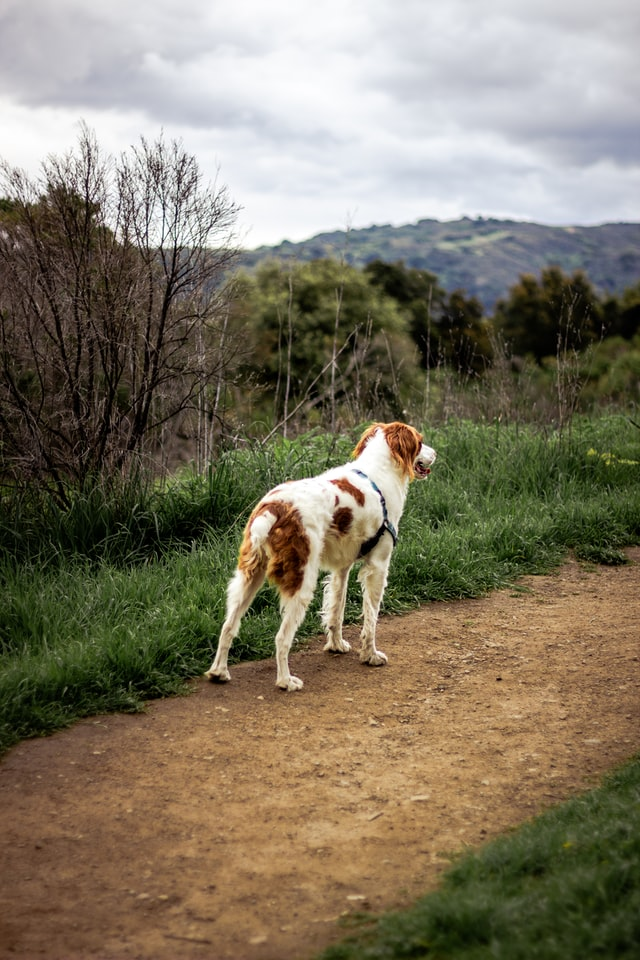

In [16]:
 # Japanese: A dog in a park
search("公園の犬")